In [ ]:
# MAIN

In [ ]:
# MAIN

env = 'pc'  # 'colab' or 'pc'

using_gpu = False  # True or False

percentage = 0.07
train_percentage = percentage  # how much of train set we will use
val_percentage = percentage
test_percentage = percentage

saving_models = True
saving_train_times = True
saving_histories = True
n_trial = 2

git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Covid19Classifier/model_evaluation/'

# Number of trial for this day (-> directory/24-01-22/trial-{n_trial}/ -- example of directories)

# Packages & functions

In [ ]:
# %%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    
    files = [
            'DataProperties.py',
            'DatasetParameters.py',
            'Preprocessing.py',
            'PreprocessingParameters.py',
            
            'Model.py',
            'BNModel.py',
            'CNNModel.py',
            'VGG19Model.py',
            'VGG16Model.py',
            'AlexNetModel.py',
            'DropoutModel.py',
            'InceptionModel.py',
            'ResNetModel.py',

            'Utils.py',
            'ModelUtils.py',
            'TimeCallBack.py'
    ]

In [ ]:
%%capture
if env == 'colab':
    url_dict = {file: git_download_path + file for file in files[:3]}
    download_files(url_dict)

In [ ]:
%%capture
if env == 'colab':
    url_dict = {file: git_download_path + file for file in files[3:6]}
    download_files(url_dict)

In [ ]:
%%capture
if env == 'colab':
    url_dict = {file: git_download_path + file for file in files[6:]}
    download_files(url_dict)

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Models
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D as Conv2D
from tensorflow.keras.layers import BatchNormalization as BatchNormalization
from tensorflow.keras.layers import ReLU as ReLU
from tensorflow.keras.layers import MaxPool2D as MaxPool2D
from tensorflow.keras.layers import Flatten as Flatten
from tensorflow.keras.layers import Dense as Dense
from tensorflow.keras.layers import Input as Input

from os.path import isdir
import os
import numpy as np

# Plotting
# import seaborn as sns

# Utils
import importlib
from os.path import isdir
# from datetime import date
import pandas as pd

# Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import DataProperties 
import PreprocessingParameters 
import Preprocessing
import DatasetParameters
import Utils
import CNNModel
import BNModel
import ResNetModel
import DropoutModel
import InceptionModel
import AlexNetModel
import VGG19Model
import VGG16Model
import Model
import ModelUtils
import TimeCallBack

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        DataProperties,
        PreprocessingParameters,
        DatasetParameters,
        Utils,
        Preprocessing,

        Model,
        CNNModel,
        BNModel,
        DropoutModel,
        
        VGG16Model,
        ResNetModel,
        InceptionModel,
        ModelUtils,
        TimeCallBack,
        VGG19Model,
        AlexNetModel
    ]
)

from DataProperties import DataProperties
from PreprocessingParameters import PreprocessingParameters
from DatasetParameters import DatasetParameters
from Utils import *
from Preprocessing import *
from CNNModel import CNNModel
from BNModel import BNModel
from DropoutModel import DropoutModel
from VGG19Model import VGG19Model
from ResNetModel import ResNetModel
from InceptionModel import InceptionModel
from ModelUtils import ModelUtils
from TimeCallBack import TimeCallBack
from AlexNetModel import AlexNetModel
from VGG16Model import VGG16Model

In [ ]:
DataProps = DataProperties(
    environment = env,
    n_trial = n_trial
)

# Class balance

## Paths download

In [ ]:
assert isdir(DataProps.train_data_path) == True
assert isdir(DataProps.test_data_path) == True
assert isdir(DataProps.val_data_path) == True
assert isdir(DataProps.models_path) == True

In [ ]:
train_files = calc_files(directory = DataProps.train_data_path)
train_covid_files = calc_files(DataProps.train_covid_path)
train_pn_files = calc_files(DataProps.train_pneumonia_path)
train_healthy_files = calc_files(DataProps.train_healthy_path)

assert train_files == (train_covid_files + train_pn_files + train_healthy_files)

In [ ]:
val_files = calc_files(directory = DataProps.val_data_path)
val_covid_files = calc_files(DataProps.val_covid_path)
val_pn_files = calc_files(DataProps.val_pneumonia_path)
val_healthy_files = calc_files(DataProps.val_healthy_path)

assert val_files == (val_covid_files + val_pn_files + val_healthy_files)

In [ ]:
test_files = calc_files(DataProps.test_data_path)
test_covid_files = calc_files(DataProps.test_covid_path)
test_pn_files = calc_files(DataProps.test_pneumonia_path)
test_healthy_files = calc_files(DataProps.test_healthy_path)

assert test_files == (test_covid_files + test_pn_files + test_healthy_files)

Text(0, 0.5, 'y')

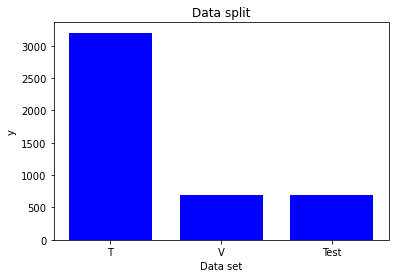

In [ ]:
x = ['T', 'V', 'Test']
y = [train_files, val_files, test_files]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ax.bar(x, y, width, color="blue")
plt.title('Data split')
plt.xlabel('Data set')
plt.ylabel('y') 

In [ ]:
train_covid_files, train_healthy_files, train_pn_files

(1067, 1067, 1067)

In [ ]:
val_covid_files, val_healthy_files, val_pn_files

(229, 229, 229)

In [ ]:
test_covid_files, test_healthy_files, test_pn_files

(229, 229, 229)

In [ ]:
train_files + val_files + test_files

4575

# Creating dataset

## Train

In [ ]:
train_generator = ImageDataGenerator(
    # we use only a portion for train data (initially, to check if all works fine)
    validation_split = 1 - train_percentage,  

    # preprocessing
    preprocessing_function = Preprocessing.preprocess,
    samplewise_center = DatasetParameters.samplewise_center,
    featurewise_center = DatasetParameters.featurewise_center,
    
    # augmentation
    width_shift_range = DatasetParameters.width_shift_range,
    height_shift_range = DatasetParameters.height_shift_range,
    rotation_range = DatasetParameters.rotation_range,
    horizontal_flip = DatasetParameters.horizontal_flip,
    vertical_flip = DatasetParameters.vertical_flip,
    # brightness_range = [0.8, 1.0],
    zoom_range = DatasetParameters.zoom_range
)

train_flow = train_generator.flow_from_directory(
    directory = DataProps.train_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',  # 1D integer labels
    batch_size = DatasetParameters.batch_size,
    subset = 'training',
    shuffle = DatasetParameters.shuffle_train,
    seed = DatasetParameters.seed
)
print(f'Use {train_flow.n} images for train')

Found 225 images belonging to 3 classes.
Use 225 images for train


## Validation

In [ ]:
val_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.preprocess,
    validation_split = 1 - val_percentage
)

val_flow = train_generator.flow_from_directory(
    directory = DataProps.val_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',  # 1D integer labels
    batch_size = DatasetParameters.batch_size,
    subset = 'training',  # yes, training - we use val_split of data 
    shuffle = DatasetParameters.shuffle_validation,
    seed = DatasetParameters.seed
)

print(f'Use {val_flow.n} images for validation')

Found 51 images belonging to 3 classes.
Use 51 images for validation


## Test

In [ ]:
test_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.preprocess,
    validation_split = 1 - test_percentage
)

test_flow = test_generator.flow_from_directory(
    directory = DataProps.test_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',
    shuffle = DatasetParameters.shuffle_test,
    seed = DatasetParameters.seed,
    batch_size = 1,
    subset = 'training'
)

print(f'Use {test_flow.n} images for test')

Found 51 images belonging to 3 classes.
Use 51 images for test


In [ ]:
assert train_flow.class_indices == test_flow.class_indices
assert train_flow.class_indices == val_flow.class_indices

# Visualizing dataset

(32, 300, 300, 3) 1.0


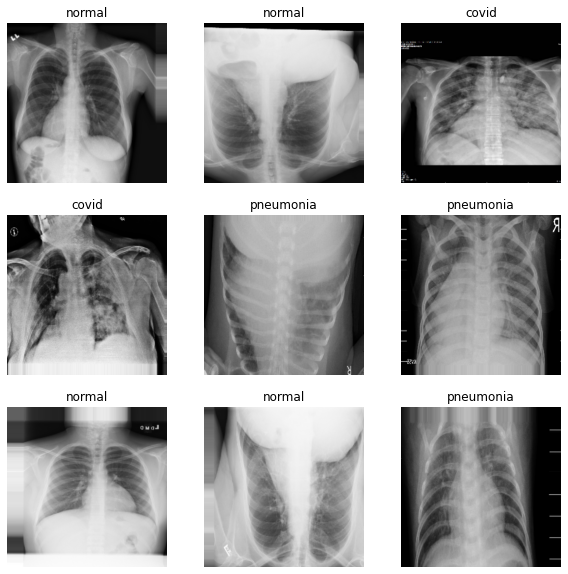

In [ ]:
how_many_to_show = 9
flow = train_flow
for _ in range(1):
    batch, labels = flow.next()
    print(batch.shape, np.max(batch))
    assert np.max(batch) <= 1.01
    assert np.min(batch) >= 0.0
    
    visualize(
        batch, 
        labels, 
        how_many_to_show, 
        class_indices = flow.class_indices,
        figsize=(10, 10)
    )

# Fitting models

## Prepare steps

In [ ]:
train_steps = train_flow.n // train_flow.batch_size
validation_steps = val_flow.n // val_flow.batch_size
test_steps = test_flow.n // test_flow.batch_size

what_to_monitor = 'val_loss'
validation_data = val_flow
validation_steps = validation_steps

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = what_to_monitor,
    patience = 2,  # 3
    mode = 'auto',
    restore_best_weights = True
)

print(f'Train steps: {train_flow.n, train_steps}')
print(f'Val steps: {val_flow.n, validation_steps}')

Train steps: (225, 7)
Val steps: (51, 1)


## Get_models()

In [ ]:
def get_empty_models():
    res = {
        'CNN': CNNModel(name = 'CNN'),
        'VGG19': VGG19Model(name = 'VGG19'),
        'VGG16': VGG16Model(name = 'VGG16'),
        'BN': BNModel(name = 'BN_CNN'),
        'Dropout': DropoutModel(name = 'Dropout'),
        'AlexNet': AlexNetModel(name = 'AlexNet')
    }
    return res
    
def construct_utils(model_name):
    return ModelUtils(

        model_params_dict = dict(**model_params),

        checkpoint_params_dict = dict(
            filepath = f'{DataProps.checkpoint_path}{model_name}/',
            **checkpoint_params
        ),

        train_params_dict = dict(
            **train_params
        )
    )

def get_models(model_names):
    empty_models = get_empty_models()
    empty_model_names = list(empty_models.keys())
    res = {}

    for name in model_names:
        assert name in empty_model_names
        model = empty_models[name]
        utils = construct_utils(name)

        res.update(
            {
                name: {
                    'model': model,
                    'utils': utils
                }
            }
        )
    return res

In [ ]:
train_params = dict(
    train_flow = train_flow,
    train_steps = train_steps,

    val_flow = validation_data,
    val_steps = validation_steps,

    epochs = 3  # DatasetParameters.epochs
)

model_params = dict(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['acc'] 
)

checkpoint_params = dict(
    save_freq = 'epoch',
    save_weights_only = True,
    save_best_only = False,
    verbose = 1
)

In [ ]:
names = ['Dropout', 'CNN']
models = get_models(names)

In [ ]:
if using_gpu:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print(
            '\n\nThis error most likely means that this notebook is not '
            'configured to use a GPU.  Change this in Notebook Settings via the '
            'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
        raise SystemError('GPU device not found')

## Summaries

In [ ]:
for name in names:
    print(f'\nPrinting summary of {name}')
    print_summary(models, name)


Printing summary of Dropout
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 300, 300, 16)      448       
_________________________________________________________________
activation_8 (Activation)    (None, 300, 300, 16)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 150, 150, 16)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 150, 150, 32)      4640      
_________________________________________________________________
activation_9 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPool

## Fit

In [ ]:
def fit_models(models_dict):

    histories = {}
    for model_name, parameters in models_dict.items():
        
        print(f'\nFitting {model_name}')
        model = parameters['model']
        utils = parameters['utils']
        
        model.construct_model()
        model.compile_model(**utils.model_params_dict)

        checkpoint = tf.keras.callbacks.ModelCheckpoint(**utils.checkpoint_params_dict)

        callbacks = [
            early_stop,
            checkpoint,
            model.epoch_time_callback
        ]

        if using_gpu:
            print(f'Fitting with GPU')
            with tf.device(device_name):
                history = fit_(
                    **utils.train_params_dict,
                    model = model.model,
                    callbacks = callbacks
                )
        else:
            print(f'Fitting without GPU')
            history = fit_(
                **utils.train_params_dict,
                model = model.model,
                callbacks = callbacks
            )
        histories[model_name] = history  

        if saving_models:
            save_dir = f'{DataProps.models_path}{model.name}/'
            
            if not(isdir(save_dir)):
                os.mkdir(save_dir)
            assert os.path.isdir(save_dir) == True
            
            print(f'saving model to dir: {save_dir}')
            model.save_model(
                dir = save_dir
            )

    if saving_histories:
        print(f'Saving histories to {DataProps.histories_path}')
        save_histories(histories, DataProps.histories_path)

    
    if saving_train_times:
        save_times_dir = DataProps.models_path + 'training_time.csv'
        print(f'Saving training times to {save_times_dir}')
        save_train_times(
            models_dict = models,
            save_dir = save_times_dir
        )

    return histories


Fitting Dropout
Fitting without GPU
ERROR:tensorflow:Couldn't match files for checkpoint C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Checkpoints/2022-01-29/Dropout\.
Epoch 1/3
6/7 [========================>.....] - ETA: 1s - loss: 3.1982 - acc: 0.2919
Epoch 00001: saving model to C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Checkpoints/2022-01-29/Dropout/
7/7 [==============================] - 15s 2s/step - loss: 2.9326 - acc: 0.3109 - val_loss: 1.1081 - val_acc: 0.1250
Epoch 2/3
6/7 [========================>.....] - ETA: 2s - loss: 1.0940 - acc: 0.3802
Epoch 00002: saving model to C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Checkpoints/2022-01-29/Dropout/
7/7 [==============================] - 15s 2s/step - loss: 1.0974 - acc: 0.3782 - val_loss: 1.0999 - val_acc: 0.0938
Epoch 3/3
6/7 [========================>.....] - ETA: 2s - loss: 1.0898 - acc: 0.4271
Epoch 00003: saving model to C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Checkpoints/2022-01-29/Dropout/
7/7 [=============================

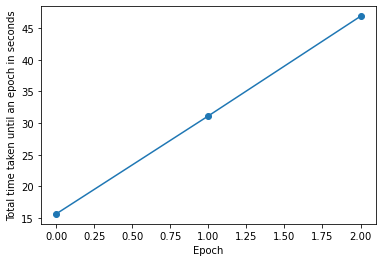

saving model to dir: C:/Users/79137/Pasha/2. UNIPD/HDA/Project/SavedModels//2022-01-29/trial-2/Dropout/

Fitting CNN
Fitting without GPU
ERROR:tensorflow:Couldn't match files for checkpoint C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Checkpoints/2022-01-29/CNN\.
Epoch 1/3
6/7 [========================>.....] - ETA: 2s - loss: 45.7214 - acc: 0.2969
Epoch 00001: saving model to C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Checkpoints/2022-01-29/CNN/
7/7 [==============================] - 18s 3s/step - loss: 44.9301 - acc: 0.3005 - val_loss: 38.2180 - val_acc: 0.0000e+00
Epoch 2/3
6/7 [========================>.....] - ETA: 1s - loss: 34.9476 - acc: 0.3385
Epoch 00002: saving model to C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Checkpoints/2022-01-29/CNN/
7/7 [==============================] - 15s 2s/step - loss: 34.3389 - acc: 0.3348 - val_loss: 29.4653 - val_acc: 0.5312
Epoch 3/3
6/7 [========================>.....] - ETA: 1s - loss: 26.8085 - acc: 0.3769
Epoch 00003: saving model to C:/Users/

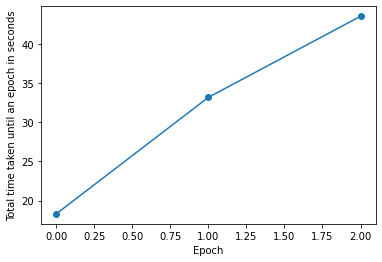

saving model to dir: C:/Users/79137/Pasha/2. UNIPD/HDA/Project/SavedModels//2022-01-29/trial-2/CNN/
Saving histories to C:/Users/79137/Pasha/2. UNIPD/HDA/Project/SavedModels//2022-01-29/trial-2/Histories/
Saving training times to C:/Users/79137/Pasha/2. UNIPD/HDA/Project/SavedModels//2022-01-29/trial-2/training_time.csv


In [ ]:
histories = fit_models(
    models_dict = models
)

In [ ]:
histories

{'Dropout': <tensorflow.python.keras.callbacks.History at 0x1f41b32e2c8>,
 'CNN': <tensorflow.python.keras.callbacks.History at 0x1f41d7e1888>}

In [ ]:
# To check if bugs
if 'CNN' in names:
    m = collect_metrics(
        {'CNN': models['CNN']['model']}, test_flow, test_steps
    )

51/51 [==============================] - 2s 32ms/step - loss: 22.1245 - acc: 0.3922


C:\Users\79137\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
if 'Dropout' in names:
    m = collect_metrics(
            {'Dropout': models['Dropout']['model']}, test_flow, test_steps    
        )

51/51 [==============================] - 1s 23ms/step - loss: 1.0803 - acc: 0.3922


C:\Users\79137\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Models evaluation

## Full training time

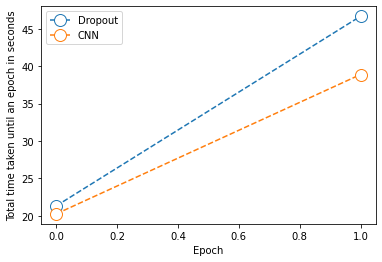

In [ ]:
# visualize_full_train_time(
#     models_dict = models
# )

## Seconds per epoch

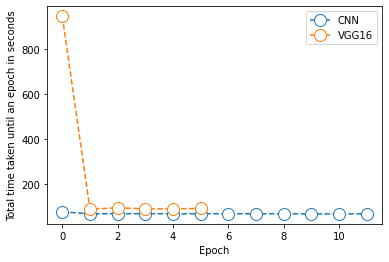

In [ ]:
# visualize_epoch_time(
#     models_dict = models
# )

## Test flow performance

In [ ]:
# if using_gpu:
#     print(f'Fitting with GPU')
#     with tf.device(device_name):
#         metrics_dict = collect_metrics(models, test_flow, test_steps)
# else:
#     metrics_dict = collect_metrics(models, test_flow, test_steps)

Fitting with GPU
345/345 [==============================] - 10s 27ms/step - loss: 1.0986 - acc: 0.3333


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# def normalize_col(df, colnames):
#     for c in colnames:
#         df[c + '_norm'] = df[c] / np.max(df[c])

# test_metrics_df = pd.DataFrame(metrics_dict).transpose()

# normalize_col(
#     test_metrics_df,
#     [
#         'data_eval_time_sec',
#         'tr_params',
#         'test_loss^(-1)'
#     ]
# )

In [ ]:
# test_metrics_df.head()

,data_eval_time_sec,data_size,test_loss^(-1),test_accuracy,F1,precision,recall,tr_params,data_eval_time_sec_norm,tr_params_norm,test_loss^(-1)_norm
CNN,6.061675,345.0,0.919629,0.811594,0.807152,0.814563,0.811594,10788643.0,0.588238,0.080349,0.837058
VGG16,10.304803,345.0,1.098645,0.333333,0.166667,0.111111,0.333333,134272835.0,1.000000,1.000000,1.000000


In [ ]:
# if saving_metrics_report:
#     print(f'Saving metrics to {DataProps.models_path}')
#     test_metrics_df.to_csv(DataProps.models_path + 'test_metrics_res.csv')

Saving metrics to /content/drive/MyDrive/UNIPD/HDA/Project/SavedModels//2022-01-28/trial-2/


<Figure size 1080x1080 with 0 Axes>

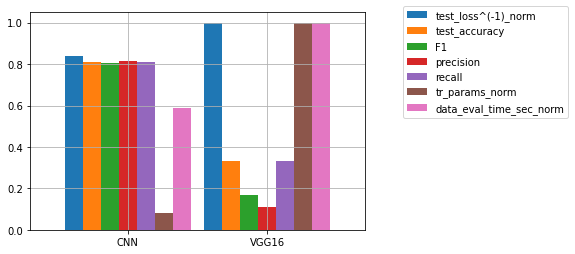

In [ ]:
# metrics_to_show = [
#                    'test_loss^(-1)_norm',
#                    'test_accuracy',
#                    'F1',
#                    'precision',
#                    'recall',
                   
#                    'tr_params_norm',
#                    'data_eval_time_sec_norm'
# ]

# plt.figure(figsize = (15, 15))
# ax = test_metrics_df.loc[:, metrics_to_show].plot.bar(
#     rot = 0,
#     width = 0.9
# )
# plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.grid()

## Confusion matrices

In [ ]:
# models

{'CNN': <CNNModel.CNNModel at 0x7fcd921a5d90>,
 'VGG16': <VGG16Model.VGG16Model at 0x7fcd921a5ad0>}

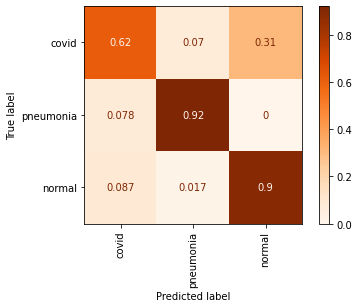

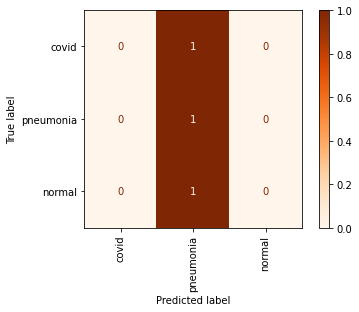

In [ ]:
# for m_name, model in models.items():
#     test_flow.reset()
#     plot_confusion_matrix(
#         Y_true = test_flow.classes, 
#         Y_pred = model.flow_predict(
#             test_flow,
#             test_steps
#         ),
#         class_indices = test_flow.class_indices
#     )

## Learning curves

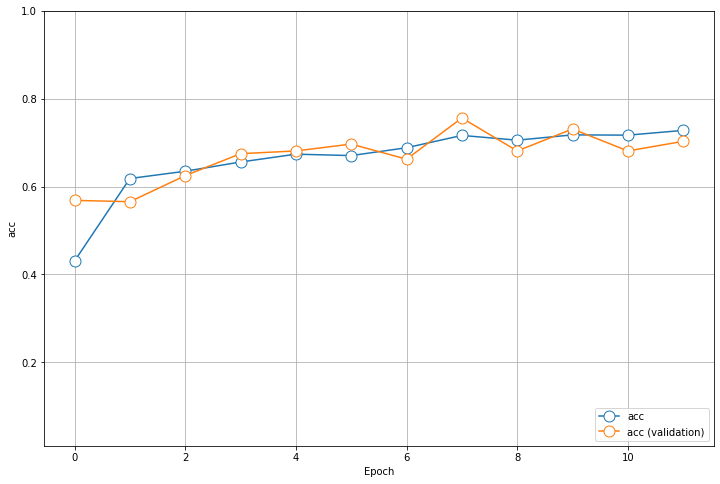

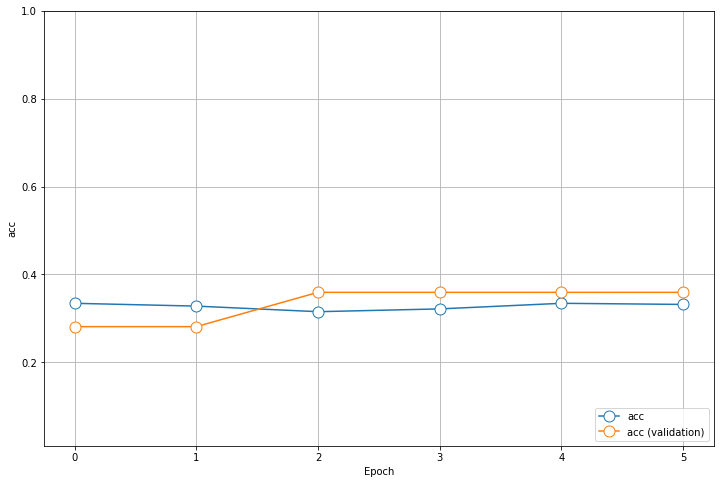

In [ ]:
# for m_name, history in histories.items():
#     plot_history(
#         history = history.history,
#         metrics_name = 'acc',
#         plot_validation = True
#     )

## Layers interpretation

In [ ]:
# train_flow[0][0][0].shape

(300, 300, 3)

We have:
        3 by 3 kernel, 
        of 3 color channels,
        total: 16 kernels


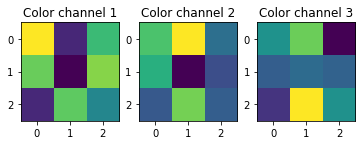

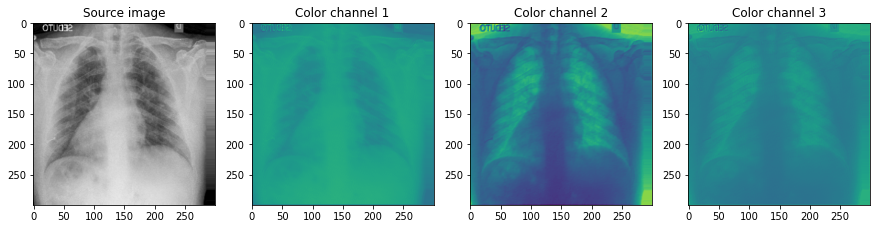

In [ ]:
# visualize_kernel_work(
#     model = models['CNN'].model, 
#     n_layer = 0, 
#     n_kernel = 0, 
#     image = train_flow[0][0][10],  # 10th image
#     label = train_flow[0][1][10],  # 10th image 
#     n_color_channels = PreprocessingParameters.n_color_channels[0]
# )

We have:
        3 by 3 kernel, 
        of 16 color channels,
        total: 32 kernels


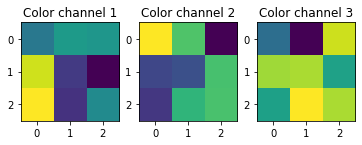

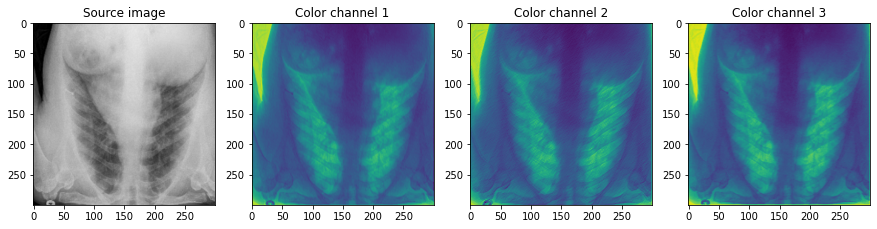

In [ ]:
# visualize_kernel_work(
#     model = models['CNN'].model, 
#     n_layer = 2,
#     n_kernel = 0, 
#     image = train_flow[0][0][10],  # 10th image
#     label = train_flow[0][1][10],  # 10th image 
#     n_color_channels = PreprocessingParameters.n_color_channels[0]
# )

We have:
        3 by 3 kernel, 
        of 64 color channels,
        total: 256 kernels


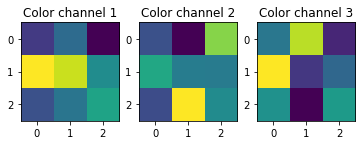

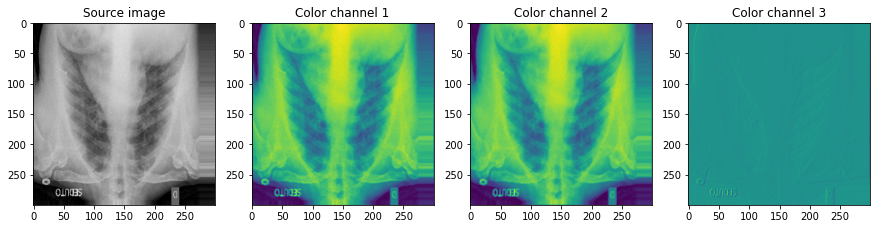

In [ ]:
# visualize_kernel_work(
#     model = models['CNN'].model,
#     n_layer = 6,
#     n_kernel = 0, 
#     image = train_flow[0][0][10],  # 10th image
#     label = train_flow[0][1][10],  # 10th image 
#     n_color_channels = PreprocessingParameters.n_color_channels[0]
# )